In [6]:
import onnxruntime as ort
import numpy as np

ort_encoder = ort.InferenceSession('vae_encoder.onnx')
ort_decoder = ort.InferenceSession('vae_decoder.onnx')

2025-01-31 10:32:42.235710759 [W:onnxruntime:, graph.cc:109 MergeShapeInfo] Error merging shape info for output. 'encoder_1' source:{} target:{1}. Falling back to lenient merge.


In [7]:
import pandas as pd

file = "/home/doserbd/data/gaia/xp_sampled_mean_spectrum/csv/XpSampledMeanSpectrum_000000-003111.csv.gz"
gaia = pd.read_csv(file, comment='#', nrows=12)

In [8]:
list_of_arrays = [
    "flux",
    "flux_error",
]

for array in list_of_arrays:
    gaia[array] = gaia[array].apply(
        lambda x: np.fromstring(x[1:-1], dtype=np.float32, sep=",")
    )

In [9]:
gaia["flux"] = gaia["flux"].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
gaia["flux"] = gaia["flux"].apply(lambda x: np.append(x, x[-1]))

In [10]:
data = np.array(gaia["flux"].values.tolist())
data = data.reshape(-1, 1, 344)
data.shape

(12, 1, 344)

In [11]:
z = ort_encoder.run(['div'], {'l_x_': data})
recon = ort_decoder.run(None, {'l_x_': z[0]})
recon[0].shape

(12, 1, 344)

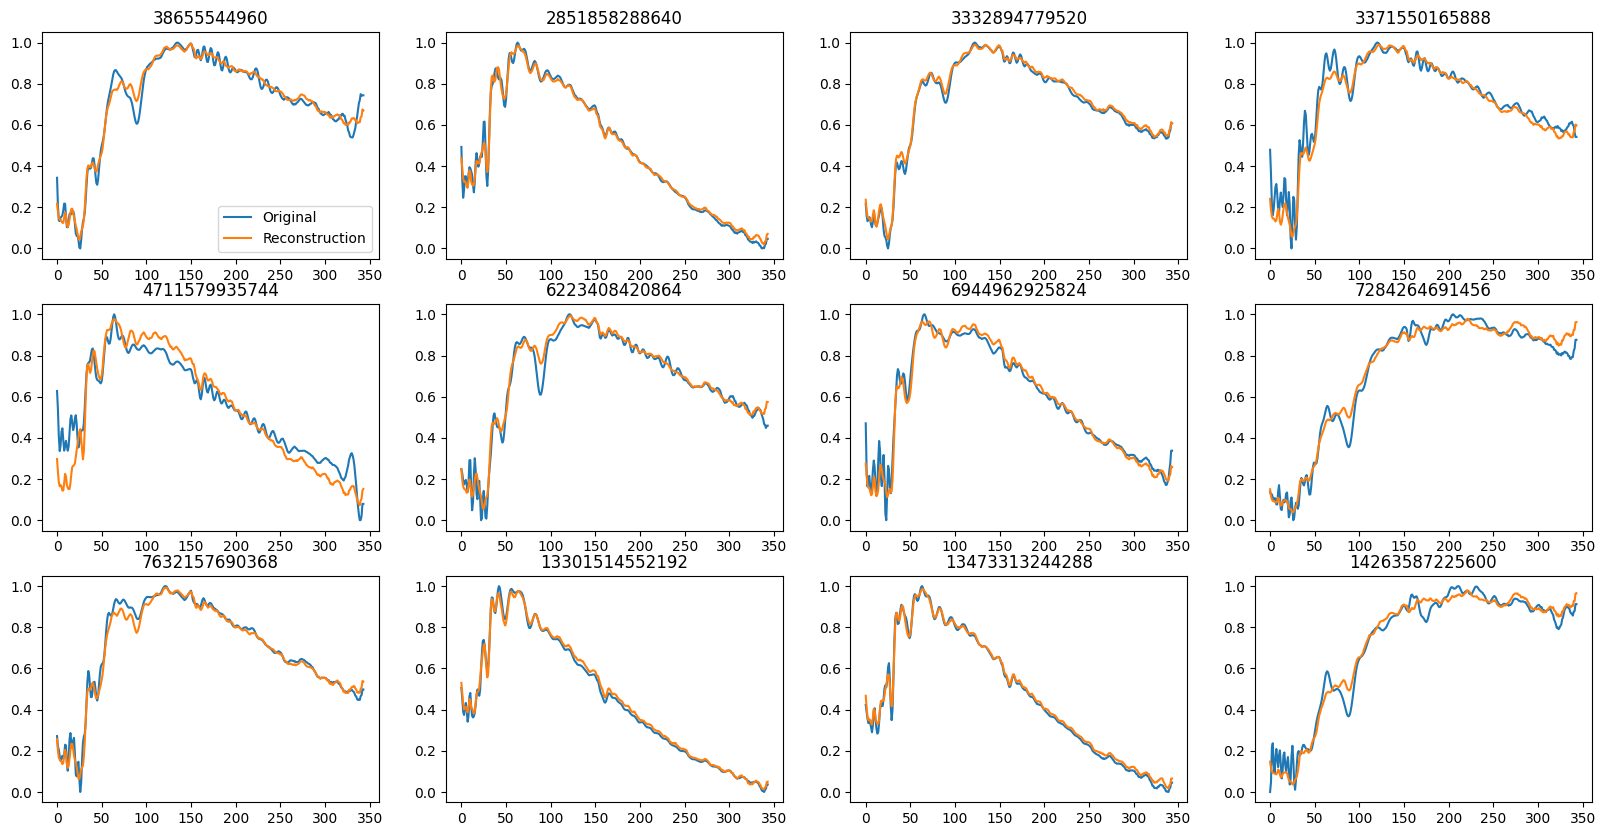

In [16]:
from matplotlib import pyplot as plt

nb_samples = 12
fig, ax = plt.subplots(3, 4)
ax = ax.flatten()
fig.set_size_inches(20, 10)
for idx in range(nb_samples):
# for idx in [0]:
    ax[idx].set_title(f"{gaia["source_id"][idx]}")
    ax[idx].plot(data[idx][0], label="Original")
    ax[idx].plot(recon[0][idx][0], label="Reconstruction")
    if idx == 0:
        ax[idx].legend(loc="lower right")
fig.savefig("reconstruction.png", bbox_inches='tight')